In [1]:
import pandas as pd
import numpy as np

In [2]:
notebooks_data = "/workspace/notebooks_data/"

In [3]:
import os, sys, argparse
import pandas as pd
import numpy as np
import subprocess
from itertools import groupby

epitope_csv = notebooks_data + "epitope_table_export_1478815050.csv"
swiss_db_path = "/workspace/blast/swiss/swissprot"

max_epitope_len = 12
min_epitope_len = 5
generated_sample_len = 28

# https://www.biostars.org/p/710/
def __fasta_iter(fasta_name):
    fh = open(fasta_name)
    # ditch the boolean (x[0]) and just keep the header or sequence since
    # we know they alternate.
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in faiter:
        # drop the ">"
        header = header.next()[1:].strip()
        # join all sequence lines to one.
        seq = "".join(s.strip() for s in faiter.next())
        yield header, seq

def __create_swiss_prot_dataframe(output_path, swiss_db_path, protein_id_file):
    protein_fasta = output_path + "/" + "proteins.fasta"
    cmd = [
        "blastdbcmd", "-db", swiss_db_path, "-entry_batch", protein_id_file,
        "-out", protein_fasta
    ]
    print " ".join(cmd)
    with open(os.devnull, "w+") as devnull:
        subprocess.call(cmd, stdout=devnull, stderr=subprocess.STDOUT)
    data = []
    for (header, seq) in __fasta_iter(protein_fasta):
        header_fields = header.split('|')
        assert (header_fields[0] == 'gi')
        assert (header_fields[2] == 'sp') # Swiss-Prot ID
        gi = header_fields[3]
        data.append((gi, seq))
    return pd.DataFrame(data, columns=['protein_id', 'protein_sequence'])

# Converts the merged IEDB/Swiss-Prot table into training data [(cleaved_sample, True), (uncleaved_sample, False), ...]
def __create_training_set(output_dir, iedb_swiss_merged, generated_sample_len):
    data = []
    for (protein_id,
         row_ids) in iedb_swiss_merged.groupby("protein_id").groups.items():
        epitope_rows = iedb_swiss_merged.loc[row_ids]
        # Grab the protein sequence from the first row
        protein_sequence = epitope_rows['protein_sequence'].iloc[0]
        # Sort by the C-terminus ('end')
        sorted_epitopes = epitope_rows.sort_values(by="end")
        protein_sequence_len = len(protein_sequence)
        current_loc = 0
        for (i, epitope_sequence, start, end) in \
                sorted_epitopes[["epitope_sequence", "start", "end"]].itertuples():
            epitope_start = int(start) - 1
            epitope_end = int(end) - 1

            epitope_sequence_len = len(epitope_sequence)
            epitope_midpoint = epitope_end - epitope_sequence_len / 2
            sample_start_end = lambda pos: (pos - (generated_sample_len / 2) + 1, pos + (generated_sample_len / 2) + 1)
            cleaved_sample_pos = sample_start_end(epitope_end)
            uncleaved_sample_pos = sample_start_end(epitope_midpoint)

            # Check if our samples are off the protein sequence or overlap (TODO: handle these)
            if (uncleaved_sample_pos[0] < current_loc or
                    cleaved_sample_pos[1] > protein_sequence_len):
                continue

            current_loc = cleaved_sample_pos[1]

            # Double check that the start and end positions are correct
            assert protein_sequence[epitope_start:epitope_end + 1] == epitope_sequence,\
                     "Epitope failed to align to protein"

            fetch_seq = lambda pos: protein_sequence[pos[0]:pos[1]]
            data.append((fetch_seq(cleaved_sample_pos), 1))
            data.append((fetch_seq(uncleaved_sample_pos), 0))

    cleavage_data = pd.DataFrame(data)
    cleavage_data.columns = ['sequence', 'is_cleaved']
    return cleavage_data


def create_iedb_swiss_dataset(epitope_csv, swiss_db_path, output_dir,
                              max_epitope_len, min_epitope_len,
                              generated_sample_len):
    # Load the CSV from IEDB (skipping the first line, [2:])
    epi = pd.DataFrame.from_csv(epitope_csv)[2:]
    # Rename the columns to remove whitespace
    epi.columns = [
        'type', 'epitope_sequence', 'start', 'end', 'chebi', 'syn', 'protein',
        'protein_id', 'organism', 'oid', 'comments'
    ]
    # Remove GI entries that start with prefix "SRC"
    epi = epi[epi.protein_id.str.startswith("SRC") == False]
    # Remove entries with '+' notation (note: looking into this, e.g. "PLNISLGDVVLY + DEAM(N3)")
    epi = epi[epi.epitope_sequence.str.find('+') == -1]
    # Remove the "GI:" prefix from the GIs provided by IEDB
    epi["protein_id"] = epi.protein_id.str.replace("GI:", "")
    # Drop any epitopes that are not the desired length
    iedb_epitopes = epi[(epi.epitope_sequence.str.len() >= min_epitope_len) \
                         & (epi.epitope_sequence.str.len() <= max_epitope_len)]\
             .loc[:, ["epitope_sequence", "protein_id", "start", "end"]]
    # Create a file with a list of unique protein (antigen) IDs for use with BLAST
    antigen_ids = iedb_epitopes["protein_id"].unique()
    protein_id_file = output_dir + "/" + "protein_ids.txt"
    np.savetxt(protein_id_file, antigen_ids, fmt="%s")
    num_iedb_epitopes = iedb_epitopes.shape[0]
    num_iedb_proteins = antigen_ids.shape[0]
    print "There are %d IEDB MHC-1 epitopes from %d unique proteins (antigens)." % (
        num_iedb_epitopes, num_iedb_proteins)
    swiss_prot_db = __create_swiss_prot_dataframe(output_dir, swiss_db_path,
                                                  protein_id_file)
    print "Found %d IEDB proteins in Swiss-Prot sequence database" % (
        swiss_prot_db.shape[0])
    
    # Merge the IEDB epitops with the SWISS protein data and drop any NaN values (proteins not in SWISSprot)
    iedb_swiss_merged = pd.merge(
        iedb_epitopes, swiss_prot_db, on="protein_id", how="left").dropna()
    # Since we're going to sort on position, convert to numeric columns
    iedb_swiss_merged["start"] = pd.to_numeric(iedb_swiss_merged[
        "start"]).astype(int)
    iedb_swiss_merged["end"] = pd.to_numeric(iedb_swiss_merged["end"]).astype(
        int)
    # Save the raw merged data for reference
    iedb_swiss_merged.to_csv(output_dir + "/" + "merged_iedb_swiss.csv")
    return __create_training_set(output_dir, iedb_swiss_merged, generated_sample_len)

raw_training_data = create_iedb_swiss_dataset(epitope_csv, swiss_db_path, notebooks_data,
                              max_epitope_len, min_epitope_len,
                              generated_sample_len)


/Users/matt/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (0,3,4,5,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


There are 89237 IEDB MHC-1 epitopes from 31452 unique proteins (antigens).
blastdbcmd -db /workspace/blast/swiss/swissprot -entry_batch /workspace/notebooks_data//protein_ids.txt -out /workspace/notebooks_data//proteins.fasta
Found 9984 IEDB proteins in Swiss-Prot sequence database


In [4]:
#raw_training_data = pd.DataFrame.from_csv(notebooks_data + "training_set.csv")

In [5]:
# Read and return the Saxon test set 
def fetch_testing_data():
    df = pd.DataFrame.from_csv("data/proteasomal_cleavage/s6_in_vivo_mhc_1_ligands_dataset.csv")
    df = df[["Sequences", "Activity"]]
    df.columns = ["sequence", "is_cleaved"]
    df.is_cleaved[df.is_cleaved == -1] = 0
    return df

raw_testing_data = fetch_testing_data()

In [6]:
from aa_props import seq_to_aa_props
from sklearn.preprocessing import MinMaxScaler

# We need to remove the Saxova samples from our training set
print "There are %d training samples before removing the Saxova sequences." % (
    raw_training_data.shape[0])
raw_training_data = raw_training_data[raw_training_data.sequence.isin(
    raw_testing_data.sequence) == False]
print "There are %d training samples after filtering out Saxova." % (
    raw_training_data.shape[0])

# Filter to check for selenocysteine (TODO) and an invalid "'"
train_seq_validator = lambda seq: seq.find("U") == -1 and seq.find("'") == -1
# Testing set has two sample which are not the correct len, filter them out too
test_seq_validator = lambda seq: train_seq_validator(seq) and len(seq) == 28

process_raw_data = lambda data, is_valid: [(seq_to_aa_props(seq), is_cleaved)
             for (i, seq, is_cleaved) in data.itertuples()
             if is_valid(seq)]

# Filter AA seqs and expand to AA features
scaler = MinMaxScaler()
training_X_y = process_raw_data(raw_training_data, train_seq_validator)
testing_X_y = process_raw_data(raw_testing_data, test_seq_validator)

(training_X, training_y) = zip(*training_X_y)
(testing_X, testing_y) = zip(*testing_X_y)

# Scale the data
scaler = MinMaxScaler()
training_X = scaler.fit_transform(training_X)
testing_X = scaler.transform(testing_X)

print "Final training set has %d samples of %d raw samples." % (
    training_X.shape[0], raw_training_data.shape[0])
print "Final testing set has %d samples of %d raw samples." % (
    testing_X.shape[0], raw_testing_data.shape[0])


There are 49184 training samples before removing the Saxova sequences.
There are 49162 training samples after filtering out Saxova.
Final training set has 49159 samples of 49162 raw samples.
Final testing set has 416 samples of 419 raw samples.


In [7]:
train_file = notebooks_data + "training_data.ll"
test_file = notebooks_data + "testing_data.ll"

def create_liblinear_files():
    for (outpath, rows) in [(train_file, zip(training_y, training_X)),
                            (test_file, zip(testing_y, testing_X))]:
        with open(outpath, 'w') as out:
            for (is_cleaved, features) in rows:
                out.write("%+d " % (is_cleaved))
                for (feature_id, feature_value) in enumerate(features):
                    out.write("%d:%s " % (feature_id + 1, feature_value))
                out.write("\n")

create_liblinear_files()

In [8]:
findC = !train -C -s 0 $train_file
print "\n".join(findC)

Doing parameter search with 5-fold cross validation.
log2c= -25.00	rate=76.3787
log2c= -24.00	rate=76.9991
log2c= -23.00	rate=77.9328
log2c= -22.00	rate=78.9052
log2c= -21.00	rate=79.727
log2c= -20.00	rate=80.3637
log2c= -19.00	rate=80.616
log2c= -18.00	rate=80.8519
log2c= -17.00	rate=80.9923
log2c= -16.00	rate=81.2832
log2c= -15.00	rate=81.7348
log2c= -14.00	rate=82.3959
log2c= -13.00	rate=83.2462
log2c= -12.00	rate=84.1067
log2c= -11.00	rate=84.9488
log2c= -10.00	rate=85.8113
log2c=  -9.00	rate=86.5782
log2c=  -8.00	rate=87.1295
log2c=  -7.00	rate=87.6238
log2c=  -6.00	rate=87.9778
log2c=  -5.00	rate=88.2809
log2c=  -4.00	rate=88.3907
log2c=  -3.00	rate=88.468
log2c=  -2.00	rate=88.5555
log2c=  -1.00	rate=88.5555
log2c=   0.00	rate=88.5555
log2c=   1.00	rate=88.5921
log2c=   2.00	rate=88.6064
log2c=   3.00	rate=88.643
log2c=   4.00	rate=88.643
log2c=   5.00	rate=88.643
log2c=   6.00	rate=88.643
Best C = 8  CV accuracy = 88.643%


In [16]:
bestC = findC[-1].split(" ")[3]
print "Using C=%s to create the model from %s" % (bestC, train_file)
createModel = !train -c {bestC} -s 0 {train_file} /Users/matt/SpiderOak\ Hive/chipper/src/chipper.model
print "\n".join(createModel)

Using C=8 to create the model from /workspace/notebooks_data/training_data.ll
iter  1 act 1.263e+05 pre 1.103e+05 delta 2.287e+00 f 2.726e+05 |g| 1.648e+05 CG   5
cg reaches trust region boundary
iter  2 act 2.757e+04 pre 2.255e+04 delta 2.959e+00 f 1.463e+05 |g| 5.386e+04 CG  10
cg reaches trust region boundary
iter  3 act 9.901e+03 pre 8.358e+03 delta 3.727e+00 f 1.187e+05 |g| 1.777e+04 CG  11
cg reaches trust region boundary
iter  4 act 3.796e+03 pre 3.454e+03 delta 4.240e+00 f 1.088e+05 |g| 6.366e+03 CG  11
cg reaches trust region boundary
iter  5 act 1.508e+03 pre 1.425e+03 delta 4.509e+00 f 1.050e+05 |g| 3.205e+03 CG  30
iter  6 act 1.640e+02 pre 1.627e+02 delta 4.509e+00 f 1.035e+05 |g| 9.380e+02 CG  42


In [10]:
prediction_file = notebooks_data + "predictions.txt"
%cd $notebooks_data
predict = !predict -b 1 testing_data.ll training_data.ll.model {prediction_file}
"\n".join(predict)
%cd /workspace/notebooks/

/Users/matt/workspace/notebooks_data
/Users/matt/workspace/notebooks


Classification report with cutoff = 0.36, MCC=0.604

             precision    recall  f1-score   support

          0       0.83      0.75      0.79       208
          1       0.77      0.85      0.81       208

avg / total       0.80      0.80      0.80       416



<IPython.core.display.Javascript object>


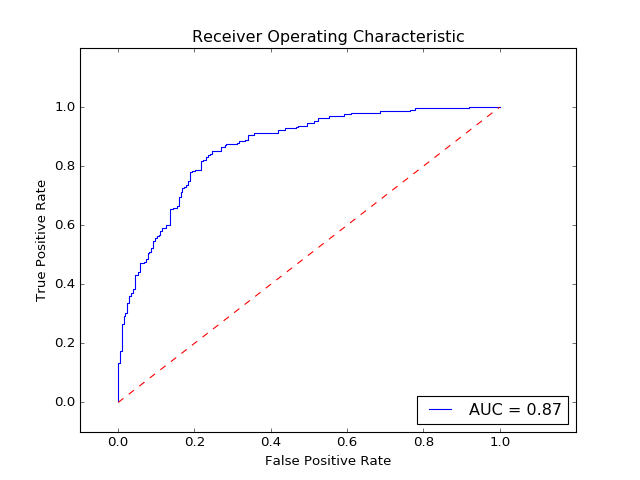

In [11]:
def fetch_prediction_regression():
    predictions = []
    with open(prediction_file, "r") as input:
        for line in input.readlines()[1:]:
            predictions.append(float(line.split(" ")[1]))
    return predictions

def fetch_prediction_classification():
    predictions = []
    with open(prediction_file, "r") as input:
        for line in input.readlines():
            predictions.append(int(line))
    return predictions

predictions = fetch_prediction_regression()
from sklearn.metrics import classification_report, matthews_corrcoef

classification_vector = lambda cutoff: [1 if pred > cutoff else 0 for pred in predictions]
def find_best_mcc():
    best_mcc = 0.0
    best_cutoff = 0.0
    for i in range(1, 100):
        pred_cutoff = i/100.0
        mcc = matthews_corrcoef(testing_y, classification_vector(pred_cutoff))
        if (mcc > best_mcc):
            best_mcc = mcc
            best_cutoff = pred_cutoff
    return (best_cutoff, best_mcc)

(best_cutoff, best_mcc) = find_best_mcc()
print "Classification report with cutoff = %.2f, MCC=%.3f\n" % (best_cutoff, best_mcc)
print classification_report(testing_y, classification_vector(best_cutoff))

%matplotlib notebook
from util.roc_curve import roc_curve
(plt, auc) = roc_curve(testing_y, predictions)
plt.show()



In [30]:
from sys import stdout as out
from aa_props import all_aa_props

scale = np.array(scaler.scale_[0:50])

scaled_aa_props = {}
for (key, values) in all_aa_props.viewitems():
    scaled_aa_props[key] = np.multiply(scale, values)

def write_aa_props(srcfile, hdrfile):
    generated_warning = """
/*** THIS IS AUTO-GENERATED SOURCE! DO NOT EDIT! ***/
"""
    header_content = """
#ifndef CHIPPER_H_DEFINED
#define CHIPPER_H_DEFINED

#include "linear.h"

#define NUM_AA_PROPERTIES 50
#define TRAINING_SET_SIZE %s
#define BEST_CUTOFF_VALUE %.2f
#define BEST_CUTOFF_MCC %.3f
#define GENERATED_SAMPLE_LEN %d
#define NUM_FEATURES (GENERATED_SAMPLE_LEN * NUM_AA_PROPERTIES)

typedef enum output_mode_t {yes_no, probability} output_mode;

int get_aa_properties(char aa, struct feature_node *features);
int predict_cleavage(char *fasta_input, char *fastq_output, char *model_file, output_mode mode);

#endif
""" % (training_X.shape[0], best_cutoff, best_mcc, generated_sample_len)
    
    with open(hdrfile, 'w') as out:
        out.write(generated_warning + header_content)
     
    aa_props_src_header = generated_warning + """
#include "chipper.h"
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

/* Amino acid properties from https://www.ncbi.nlm.nih.gov/pubmed/15895431
   Scaled to match the current model's input data. */
"""
    aa_props_src_footer = """

int get_aa_properties(char aa, struct feature_node *features) {
    int i;
    int target_aa = aa;
    /* If lowercase, make upper case */
    if ('a' <= target_aa && target_aa <= 'z') {
        target_aa -= ('a'-'A');
    }
    /* Shift to make 'A' equal to zero offset */
    target_aa -= 'A';
    if (0 <= target_aa &&  target_aa <= 25) {
        for(i = 0; i < NUM_AA_PROPERTIES; i++) {
            if (features[i].index == -1) {
                fprintf(stderr, "End of features reached before AA properties for '%c' could be set", target_aa);
                exit(EXIT_FAILURE);
            }
            features[i].value = aa_props[target_aa][i];
        }
        return aa_props[target_aa][0] == -1? 0: NUM_AA_PROPERTIES;
    } else {
        return 0;
    }
}
"""    
    with open(srcfile, "w") as out:
        out.write(aa_props_src_header)
        out.write("static const float aa_props[26][NUM_AA_PROPERTIES] = {\n")
        for key in range(ord('A'), ord('Z')+1):
            out.write("   {")
            try:
                values = scaled_aa_props[chr(key)] 
                out.write(",".join([str(i) for i in values]))
            except KeyError:
                # We scaled our values from zero to one. Mark misses with -1
                out.write(",".join([str(-1) for i in range(0, 50)]))
            out.write("}")
            if key != ord('Z'):
                out.write(",")
            out.write("\n")
        out.write("};")
        out.write(aa_props_src_footer)
        

c_code_out = "/Users/matt/SpiderOak Hive/chipper/src/"
aa_props_src = c_code_out + "aa_props.c"
aa_props_header = c_code_out + "chipper.h"
write_aa_props(aa_props_src, aa_props_header)
index_src = !gindent -linux {aa_props_src} {aa_props_header}